In [1]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(20,10)}
        )

In [3]:
connection = {'host': 'http://*********',
                      'database':'*********',
                      'user':'*********', 
                      'password':'**********'
                     }

**Task 1. Number of rows in the table ldn_listings**

In [3]:
query = '''
select count()
from ldn_listings
'''

In [10]:
num = ph.read_clickhouse(query, connection=connection)

In [11]:
num

,count()
0,85207


**Task 2 Download price data from the table depending on the type of housing.**

In [15]:
query_2 = '''
select room_type, toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
from ldn_listings
order by id
limit 1000
'''

In [16]:
df = ph.read_clickhouse(query_2, connection=connection)

In [17]:
df

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Entire home/apt,300.0
3,Private room,150.0
4,Entire home/apt,65.0
...,...,...
995,Entire home/apt,110.0
996,Entire home/apt,110.0
997,Private room,65.0
998,Entire home/apt,100.0


**Group the resulting dataframe by property type and calculate the 75th percentile of the price.**

In [22]:
df = df.groupby('room_type').quantile(.75)
# df = df.groupby(['room_type'])['price'].quantile(q=0.75).reset_index()

In [25]:
df

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


In [26]:
df[df.index == 'Private room']

,price
room_type,
Private room,70.0


**Task 3. Let's plot a scatterplot that will show the relationship between the average price and the average rating depending on the type of housing.**

In [27]:
query_3 = '''
select 
    room_type, 
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    toFloat32OrNull(review_scores_rating) as review_scores_rating
from ldn_listings
where  isNotNull(review_scores_rating)
order by id
limit 1000
'''

In [28]:
df_1 = ph.read_clickhouse(query_3, connection=connection)

In [30]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   room_type             1000 non-null   object 
 1   price                 1000 non-null   float32
 2   review_scores_rating  1000 non-null   float32
dtypes: float32(2), object(1)
memory usage: 15.8+ KB


In [46]:
df_plot = df_1.groupby('room_type').agg({'price':'mean', 'review_scores_rating': 'mean'})

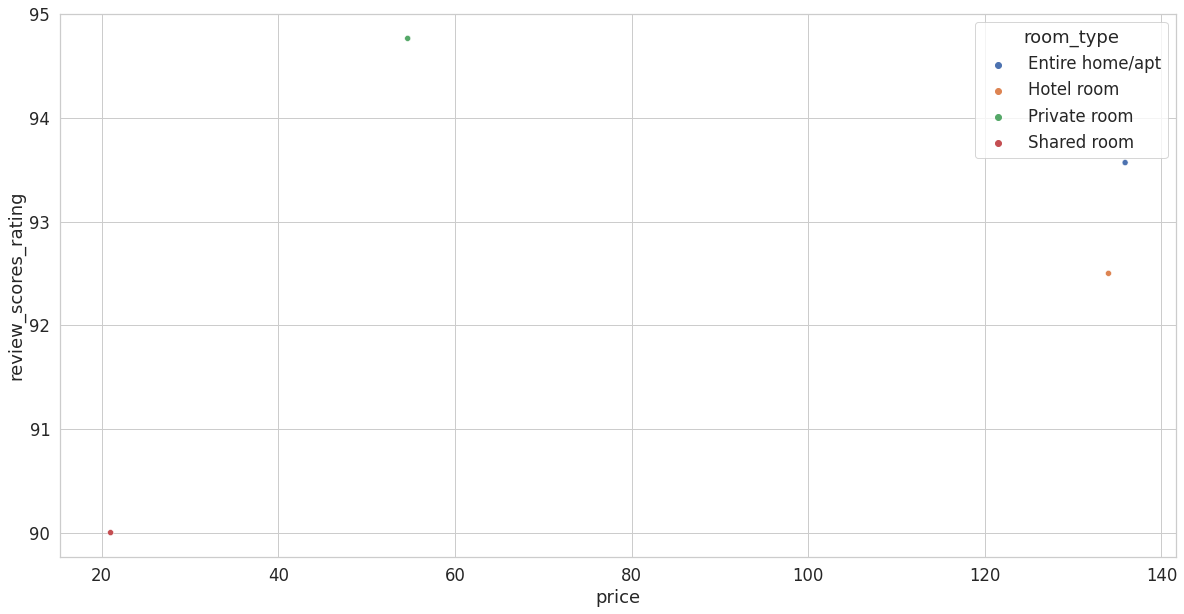

In [47]:
sns.scatterplot(x='price', y='review_scores_rating', hue='room_type', data=df_plot)

**Task 4. Let's check which account verification methods were used by hosts offering different experiences (experiences_offered != 'none').**

In [4]:
query_4 = '''
select
    DISTINCT host_id,
    host_verifications
from ldn_listings 
where  experiences_offered != 'none'
order by host_id
'''

In [38]:
df_2 = ph.read_clickhouse(query_4, connection=connection)

In [39]:
df_2

,host_id,host_verifications
0,6821,"['email', 'phone', 'facebook', 'reviews', 'jum..."
1,11431,"['email', 'phone', 'facebook', 'reviews', 'jum..."
2,27929,"['email', 'phone', 'reviews', 'jumio', 'govern..."
3,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
4,54987,"['email', 'phone', 'google', 'reviews', 'manua..."
...,...,...
1356,33365279,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,33585883,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1358,33657365,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."


In [40]:
df_2.loc[0,'host_verifications']

"['email', 'phone', 'facebook', 'reviews', 'jumio', 'government_id']"

In [12]:
import ast

In [13]:
x = ast.literal_eval(df_2.loc[0,'host_verifications'])

In [14]:
x

['email', 'phone', 'facebook', 'reviews', 'jumio', 'government_id']

In [41]:
df_2.loc[0,'host_verifications'].replace('\'', '').strip("[],").split(', ')

['email', 'phone', 'facebook', 'reviews', 'jumio', 'government_id']

In [42]:
df_2['host_verifications'] = df_2.host_verifications.apply(lambda x: x.replace('\'', '').strip("[],").split(', '))

In [43]:
type(df_2.loc[0,'host_verifications'])

list

In [50]:
df_2.explode('host_verifications').host_verifications.value_counts().to_frame(name='count').loc[['google']]

,count
google,34


**Task 5. Now let's see how many listings, and in which areas, hosts have reported impressions.**

In [59]:
query_5 = '''
select
    neighbourhood_cleansed,
    experiences_offered,
    count(id) as experiences_count
from ldn_listings 
where  experiences_offered != 'none'
group by neighbourhood_cleansed, experiences_offered
order by experiences_count desc
limit 100
'''

In [60]:
df_3 = ph.read_clickhouse(query_5, connection=connection)

In [61]:
df_3

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [62]:
df_3 = df_3.pivot_table(values='experiences_count',
    index='neighbourhood_cleansed',
    columns='experiences_offered',
    aggfunc='sum').fillna(0)

In [63]:
cmap=sns.cubehelix_palette(as_cmap=True)

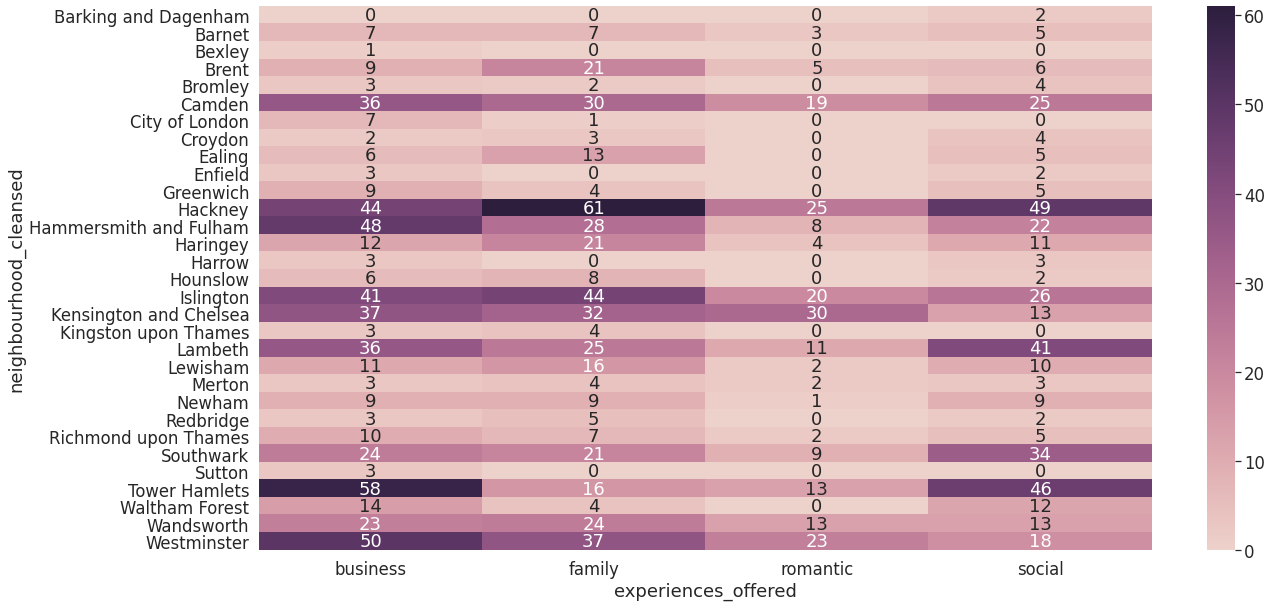

In [64]:
sns.heatmap(df_3, cmap=cmap, annot=True)

**Task 6. Download price per night data for different types of accommodation that also have an experience available.**

In [65]:
query_6 = '''
select 
    room_type, 
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price
from ldn_listings
where  experiences_offered != 'none'
'''

In [66]:
df_4 = ph.read_clickhouse(query_6, connection=connection)

In [83]:
df_4.room_type.unique()

array(['Private room', 'Entire home/apt', 'Hotel room', 'Shared room'],
      dtype=object)

**Next, draw two graphs. On the first display the original price distributions for each type of housing
On the second - logarithmic values**

In [88]:
import numpy as np

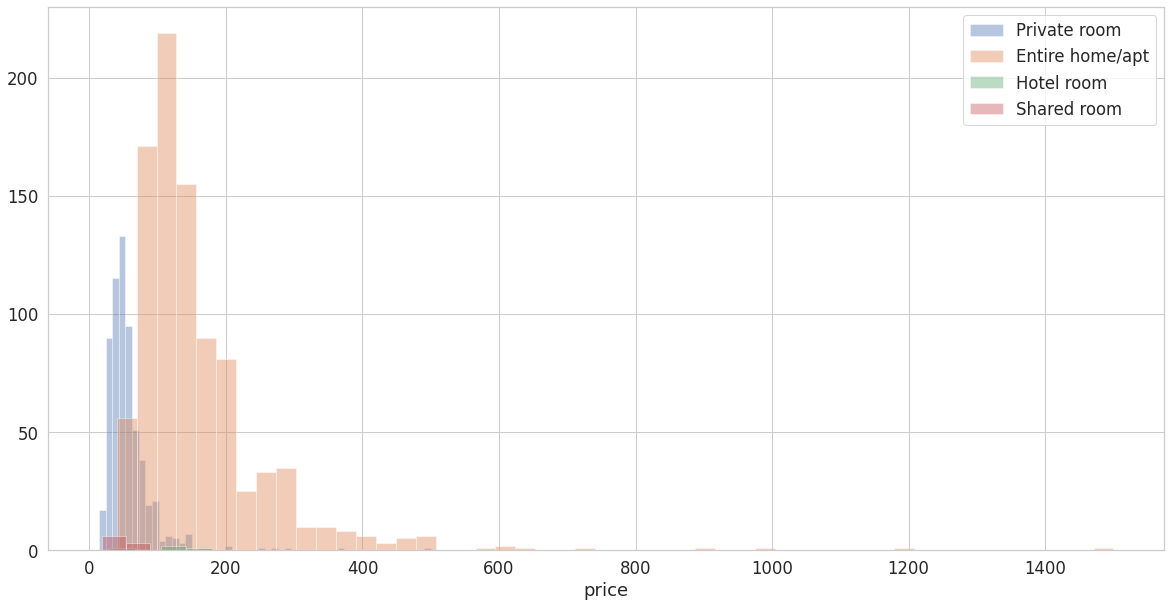

In [89]:
sns.distplot(df_4.query('room_type == "Private room"').price, kde=False, label="Private room")
sns.distplot(df_4.query('room_type == "Entire home/apt"').price, kde=False, label="Entire home/apt")
sns.distplot(df_4.query('room_type == "Hotel room"').price, kde=False, label="Hotel room")
sns.distplot(df_4.query('room_type == "Shared room"').price, kde=False, label="Shared room")
plt.legend()

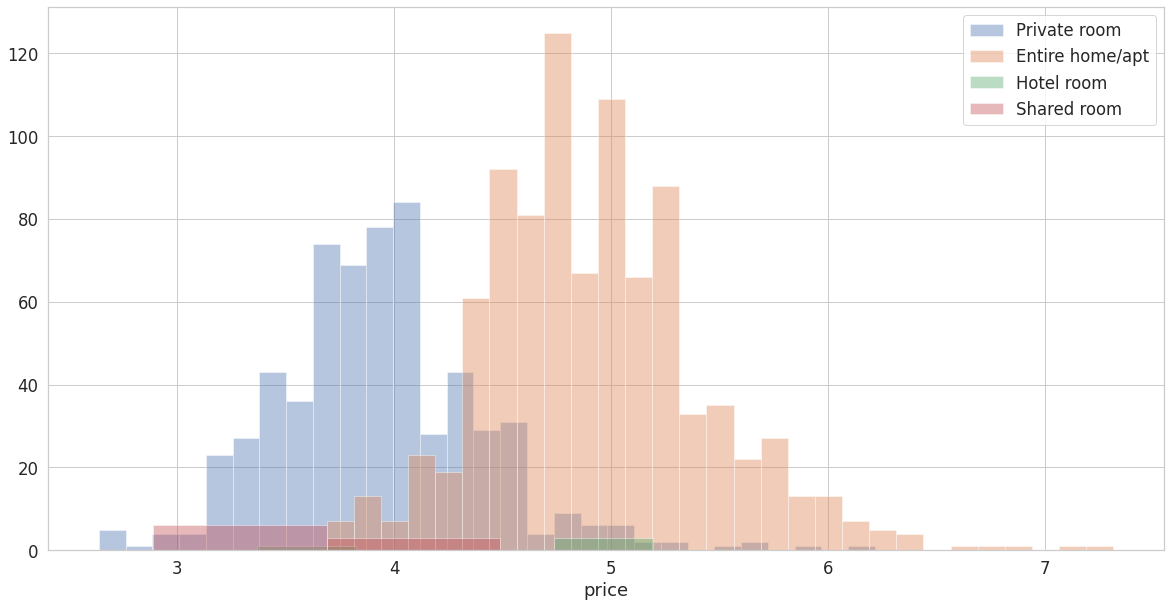

In [90]:
sns.distplot(np.log(df_4.query('room_type == "Private room"').price), kde=False, label="Private room")
sns.distplot(np.log(df_4.query('room_type == "Entire home/apt"').price), kde=False, label="Entire home/apt")
sns.distplot(np.log(df_4.query('room_type == "Hotel room"').price), kde=False, label="Hotel room")
sns.distplot(np.log(df_4.query('room_type == "Shared room"').price), kde=False, label="Shared room")
plt.legend()

**Task 7. Download price, property type, and date of first review starting January 2, 2010. Using the seaborn library and the lineplot function, plot average house prices (y-axis) versus room type (line color, 'hue' parameter) over the years (x-axis). The dataframe must be sorted by year.**

In [91]:
query_7 = '''
select 
    room_type, 
    toFloat32OrNull(replaceRegexpAll(price,'[$,]','')) as price,
    first_review
from ldn_listings
where  first_review > '2010-01-01'
limit 1000
'''

In [92]:
df_5 = ph.read_clickhouse(query_7, connection=connection)

In [93]:
df_5

,room_type,price,first_review
0,Private room,65.0,2010-08-18
1,Entire home/apt,300.0,2011-03-21
2,Entire home/apt,65.0,2016-03-05
3,Private room,29.0,2010-04-14
4,Private room,100.0,2010-10-16
...,...,...,...
995,Private room,45.0,2012-11-07
996,Private room,51.0,2013-03-18
997,Entire home/apt,79.0,2012-09-17
998,Entire home/apt,110.0,2012-09-24


In [95]:
df_5.loc[0,'first_review'][0:4]

'2010'

In [97]:
df_5['first_review'] = df_5['first_review'].apply(lambda x: x[0:4])

In [104]:
df_5 = df_5.sort_values('first_review').groupby(['room_type', 'first_review'], as_index=False).agg({'price': 'mean'})

In [106]:
df_5

,room_type,first_review,price
0,Entire home/apt,2010,103.500000
1,Entire home/apt,2011,128.792450
2,Entire home/apt,2012,135.467255
3,Entire home/apt,2013,137.887634
4,Entire home/apt,2014,154.583328
5,Entire home/apt,2015,159.380951
6,Entire home/apt,2016,99.733330
7,Entire home/apt,2017,111.666664
8,Entire home/apt,2018,125.066666
9,Entire home/apt,2019,301.666656


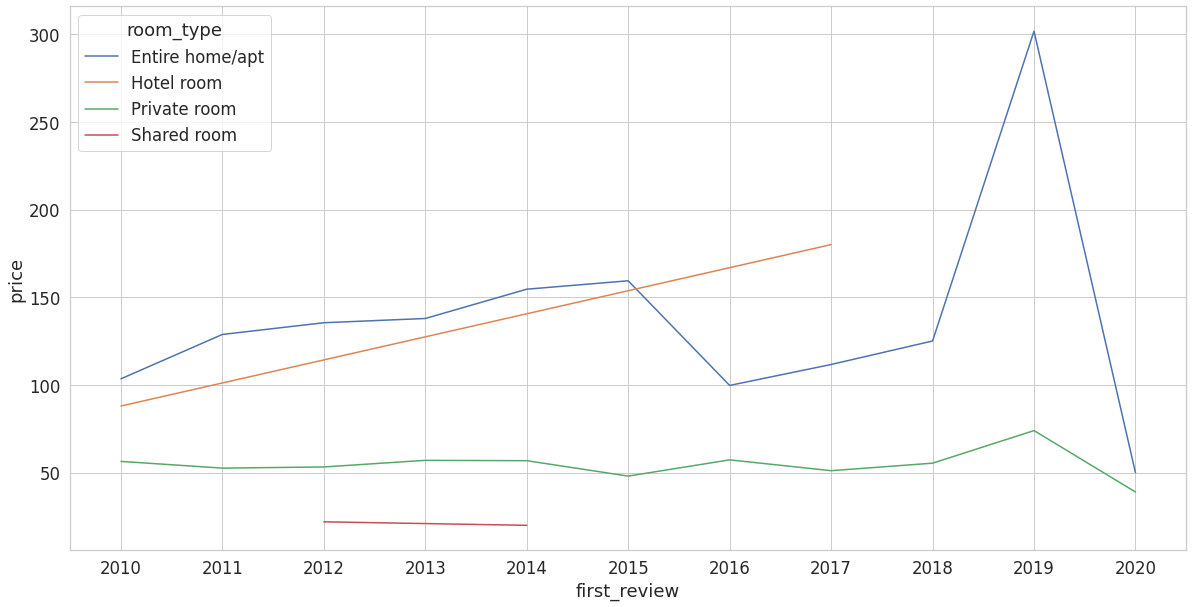

In [107]:
sns.lineplot(x='first_review', y='price', hue='room_type',data=df_5 )